In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import gsw
import scipy.stats as stats
import os
import pandas as pd
import cmocean.cm as cmo
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec

transect_label = {
    2: 'A',
    3: 'B',
    4: 'C',
    5: 'D', 
    7: 'E'
}

def moving_mean(data, n):
    """
    Calculate the running mean of a sequence with a specified window size using np.convolve.

    Args:
    - data (list or numpy array): The input sequence.
    - n (int): The size of the window.

    Returns:
    - numpy array: An array containing the running mean values.
    """
    # Define a boxcar filter with the specified window size
    boxcar_filter = np.ones(n) / n

    # Use np.convolve to calculate the running mean
    moving_mean = np.convolve(data, boxcar_filter, mode='valid')
    
    return moving_mean


# Process toyo and GPS data
If you haven't already, make sure you have a folder called "derived shipdata" in your data folder. Run this codeblock once to save GPS and processed toyo data to that folder as netCDF files. Once that is done, you can just run the next block to load them up

### Calibrate fluorescence to chlorophyll for RBR CTD

PearsonRResult(statistic=0.3924568319036647, pvalue=0.05783953275254391)


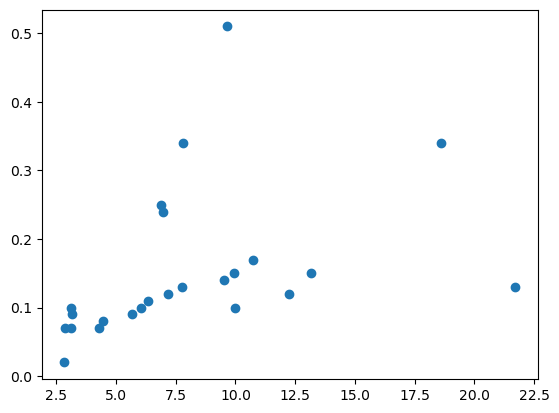

In [36]:
# calibrate fluorescence to chlorophyll
bottle_ds = pd.read_csv('../RCS data backup/data/S315_bottle_datasheet.csv').to_xarray()

# first select the bottle 13's
ds_surface = bottle_ds.where(bottle_ds.bottle == 13, drop=True)
plt.scatter(ds_surface.fluor, ds_surface.chla_045)
print(stats.pearsonr(ds_surface.fluor, ds_surface.chla_045))

LinregressResult(slope=3.752640175185216, intercept=-0.1995073644833553, rvalue=0.8530855173907705, pvalue=9.995129259297931e-14, stderr=0.35001782580446444, intercept_stderr=0.041972703105576284)
45


Text(0.5, 1.0, 'Rosette CTD calibration')

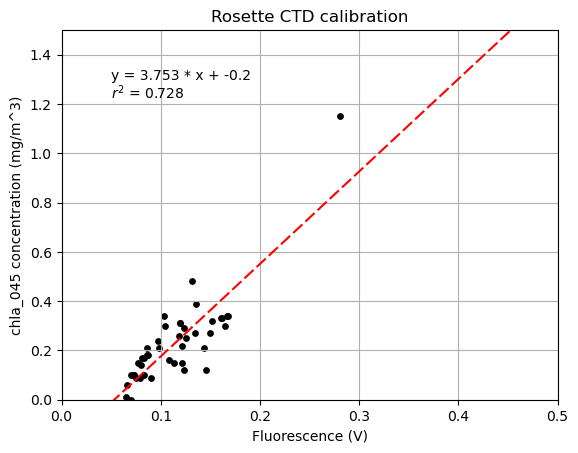

In [41]:
mask = np.all((np.invert(np.isnan(bottle_ds.chla_fluor.data)), np.invert(np.isnan(bottle_ds.chla_045.data))), axis=0)

# exclude the zero point (ctd fluorometer broken)
for i in range(len(mask)):
    if bottle_ds.chla_fluor.data[i] == 0: mask[i] = False

ctd_chla = bottle_ds.chla_fluor[mask].data
chla_045_subset = bottle_ds.chla_045[mask].data

reg_result = stats.linregress(ctd_chla, chla_045_subset)
slope = reg_result.slope
intercept = reg_result.intercept
print(reg_result)

plt.scatter(ctd_chla, chla_045_subset, color='k', s=15)
plt.plot(np.array([0,5]), np.array([0,5])*slope + intercept, dashes=[6,2], color='r')
plt.xlim(0, 0.5)
plt.ylim(0, 1.5)
plt.xlabel('Fluorescence (V)')
plt.ylabel('chla_045 concentration (mg/m^3)')
plt.grid()
plt.text(0.05, 1.3, f'y = {round(slope,3)} * x + {round(intercept,3)}')
plt.text(0.05, 1.22, fr'$r^2$ = {round(reg_result.rvalue ** 2, 3)}')
print(len(chla_045_subset))
plt.title('Rosette CTD calibration')


In [462]:
rbr_downcast

<xarray.Dataset>
Dimensions:   (index: 645)
Coordinates:
  * index     (index) int64 1155 1156 1157 1158 1159 ... 1796 1797 1798 1799
Data variables:
    Date      (index) object '2024-06-02' '2024-06-02' ... '2024-06-02'
    Time      (index) object '23:47:25' '23:47:26' ... '23:58:08' '23:58:09'
    Cond      (index) float64 56.47 56.48 56.47 56.47 ... 50.94 50.94 50.94
    Temp      (index) float64 26.81 26.82 26.82 26.82 ... 21.82 21.82 21.82
    Pres      (index) float64 10.95 11.16 11.49 11.56 ... 206.2 206.3 206.9
    Vlt       (index) float64 0.0153 0.014 0.0152 ... 0.0101 0.0106 0.0104
    Depth     (index) float64 0.8063 1.021 1.349 1.42 ... 194.5 194.6 195.2
    Salinity  (index) float64 36.02 36.02 36.02 36.02 ... 35.82 35.82 35.82
    CorrCond  (index) float64 56.39 56.4 56.4 56.39 ... 50.9 50.9 50.9 50.9
    DensAnom  (index) float64 23.55 23.55 23.55 23.55 ... 25.75 25.74 25.75

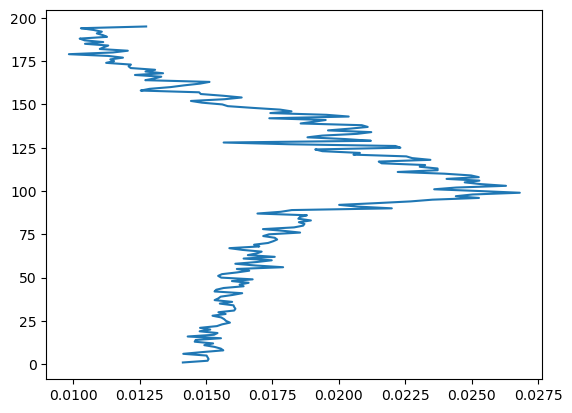

In [39]:
rbr_ds = pd.read_csv('../RCS data backup/Data/RBR_fluorescence_cal.csv').to_xarray()
ctd_ds = pd.read_csv('../RCS data backup/Data/S315_ctd.csv').to_xarray()
rbr_downcast = rbr_ds.isel(index=slice(1155,1800))
ctd_subset = ctd_ds.where(ctd_ds.station=='S315-032', drop=True)

# manually resample the RBR downcast to integer depths
depths_to_sample = np.arange(1, 196, 1)
ctd_subset = ctd_subset.isel(index=slice(0,len(depths_to_sample)))
rbr_Vlt_resampled = []

for depth in depths_to_sample:
    # find indices and linearly interpolate
    ind = rbr_downcast.index.values[np.argsort(np.abs(rbr_downcast.Depth - depth))]
    closest_depths = []
    found_lesser, found_greater = False, False
    for i in ind:
        if found_lesser or found_greater: break
        if rbr_downcast.Depth.sel(index=i) > depth:
            closest_depths.append(i)
            closest_depths.append(i - 1)
            found_greater = True
        if rbr_downcast.Depth.sel(index=i) < depth:
            closest_depths.append(i)
            closest_depths.append(i + 1)
            found_lesser = True
    closest_depths = sorted(closest_depths)

    # linearly interpolate based on depths
    depth_0 = rbr_downcast.Depth.sel(index=closest_depths[0]).data
    depth_1 = rbr_downcast.Depth.sel(index=closest_depths[1]).data
    Vlt_0 = rbr_downcast.Vlt.sel(index=closest_depths[0]).data
    Vlt_1 = rbr_downcast.Vlt.sel(index=closest_depths[1]).data
    slope = (depth - depth_0) / (depth_1 - depth_0)
    rbr_Vlt_resampled.append(Vlt_0 + slope * (Vlt_1 - Vlt_0))

plt.plot(rbr_Vlt_resampled, depths_to_sample)
#plt.plot(rbr_ds.Depth[1160:1800])
#plt.plot(rbr_ds.Vlt[1160:1800])

LinregressResult(slope=3.752640175185216, intercept=-0.1995073644833553, rvalue=0.8530855173907705, pvalue=9.995129259297931e-14, stderr=0.35001782580446444, intercept_stderr=0.041972703105576284)
45
LinregressResult(slope=4.341032680037191, intercept=0.024553744012204656, rvalue=0.9598453854272115, pvalue=1.7222028992293544e-108, stderr=0.09132543629149822, intercept_stderr=0.0015948119850466977)


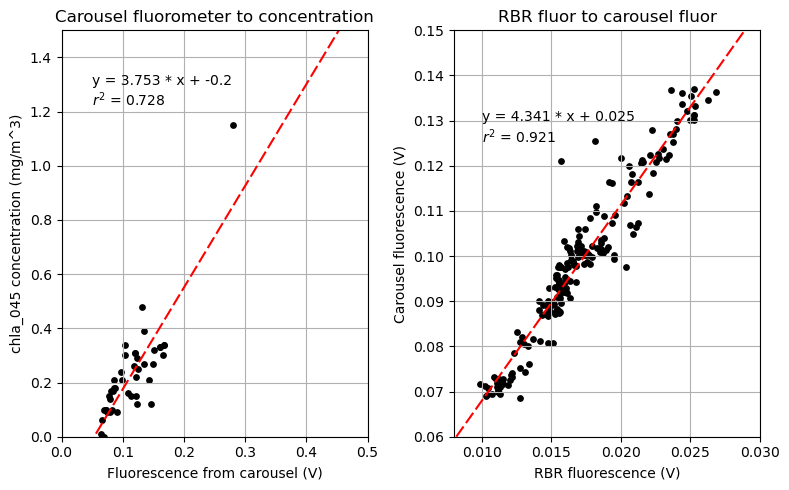

In [47]:

mask = np.all((np.invert(np.isnan(bottle_ds.chla_fluor.data)), np.invert(np.isnan(bottle_ds.chla_045.data))), axis=0)

# exclude the zero point (ctd fluorometer broken)
for i in range(len(mask)):
    if bottle_ds.chla_fluor.data[i] == 0: mask[i] = False

ctd_chla = bottle_ds.chla_fluor[mask].data
chla_045_subset = bottle_ds.chla_045[mask].data

plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
reg_result = stats.linregress(ctd_chla, chla_045_subset)
slope = reg_result.slope
intercept = reg_result.intercept
print(reg_result)

plt.scatter(ctd_chla, chla_045_subset, color='k', s=15)
plt.plot(np.array([0,5]), np.array([0,5])*slope + intercept, dashes=[6,2], color='r')
plt.xlim(0, 0.5)
plt.ylim(0, 1.5)
plt.xlabel('Fluorescence from carousel (V)')
plt.ylabel('chla_045 concentration (mg/m^3)')
plt.grid()
plt.text(0.05, 1.3, f'y = {round(slope,3)} * x + {round(intercept,3)}')
plt.text(0.05, 1.22, fr'$r^2$ = {round(reg_result.rvalue ** 2, 3)}')
print(len(chla_045_subset))
plt.title('Carousel fluorometer to concentration')

plt.subplot(1,2,2)
reg_result = stats.linregress(rbr_Vlt_resampled, ctd_subset.chla_v)
slope = reg_result.slope
intercept = reg_result.intercept
print(reg_result)
plt.scatter(rbr_Vlt_resampled, ctd_subset.chla_v, color='k', s=15)
plt.plot(np.array([0,5]), np.array([0,5])*slope + intercept, dashes=[6,2], color='r')
plt.xlim(0.008, 0.03)
plt.ylim(0.06, 0.15)
plt.xlabel('RBR fluorescence (V)')
plt.ylabel('Carousel fluorescence (V)')
plt.title('RBR fluor to carousel fluor')
plt.grid()
plt.text(0.01, 0.13, f'y = {round(slope,3)} * x + {round(intercept,3)}')
plt.text(0.01, 0.125, fr'$r^2$ = {round(reg_result.rvalue ** 2, 3)}')
plt.tight_layout()
plt.savefig('figures/fluorometer_calibration.jpg', dpi=300, bbox_inches='tight')

### Process and save Toyo datasets

In [501]:
def fluorescence_to_chla_conc(data):
    # convert RBR fluorescence to carousel fluorescence 
    carousel_fluor = data * 4.341032680037191 + 0.024553744012204656

    # now convert carousel fluoresence to chlorophyll conc 
    slope = 3.752640175185216
    intercept = -0.1995073644833553

    chla = carousel_fluor * slope + intercept
    return chla

def csv_to_xarray(filepath):
    return pd.read_csv(filepath).to_xarray()

def mask_CTD_above_water(ds, method='depth'):
    ''' Given an xarray Dataset of CTD data, try to find bad data 
        (taken above surface before deployment) and mask it out '''
    
    if method == 'depth':
        return ds.where(ds.depth > 0.5, drop=True)
    
def mask_faulty_chlorophyll(da):
    ''' Given an xarray DataArray of chlorophyll fluorescence data (V),
        find bad data due to instrument error and mask it out '''
    
    threshold = 0.08 # if voltage exceeds this value, it's probably wrong 
    return da.where(da < threshold, drop=False) 

def find_up_and_downcasts(ds):
    ''' Given a toyo dataset, add a discrete valued variable indicating
        separate up and down casts. Typically only works well with 1 min 
        averaged dataset (higher frequencies give too much noise) '''
    
    diffs = ds.depth.diff(dim='time').values
    curr_label = 0
    labels = []
    for i in range(len(diffs)):
        labels.append(curr_label)
        # the first should be a downcast, so curr_label % 2 is a good indicator for up/down
        if curr_label % 2 == 0 and diffs[i] < 0: # this is triggered if we've been going down and now going up 
            curr_label += 1
        if curr_label % 2 == 1 and diffs[i] > 0: # this is triggered if we've been going up and now going down 
            curr_label += 1
        
    labels.append(curr_label)
    
    return labels

def find_up_and_downcasts_higher_freq(ds, ds_lower_freq):
    labels = find_up_and_downcasts(ds_lower_freq)
    labels_with_time = xr.Dataset(
        data_vars=dict(
            label=('time',labels)
        ),
        coords=dict(
            time=ds_lower_freq.time
        )
    )
    labels_interp = labels_with_time.interp_like(ds, method='nearest').label
    return labels_interp


def gps_convert_valid_dec_deg(string):
    ''' Converts lat/lon values from gps to valid decimal degree format (unsigned) '''

    string = str(string)
    dec_index = string.find('.')
    if dec_index != -1:
        idx = string.find('.') - 2 # minutes always starts two left of decimal
        deg = float(string[:idx])
        minutes = float(string[idx:])
    else:
        ValueError(f'did not find decimal in {string}')
        
    dec_deg = deg + minutes / 60
    return dec_deg


def gps_convert_valid_time(string):
    ''' Formats time from raw gps to hh:mm:ss '''

    for i in range(6 - len(string)): 
        string = '0' + string

    hour = string[:2]
    minute = string[2:4]
    sec = string[4:]
    
    return f'{hour}:{minute}:{sec}'

def clean_GPS(df):
    ''' Select columns with GPS and time (UTC) data, format time to numpy 
    datetime object and location to signed decimal lat/lon '''

    # date/time
    dates = df['Date']
    times = df['Time']

    datetimes = []
    for i in range(len(times)):
        new_time = gps_convert_valid_time(str(int(times[i])))
        datetime = np.datetime64(f'{dates[i]}T{new_time}')
        datetimes.append(datetime)

    # lat/lon
    lat_raw = df['Lat']
    lon_raw = df['Lon']
    lat_hemis = df['Lat_hemis']
    lon_hemis = df['Lon_hemis']

    lat = []
    lon = []
    for i in range(len(lat_raw)):
        lat_sign = 1 if lat_hemis[i].strip() == 'N' else -1
        lon_sign = 1 if lon_hemis[i].strip() == 'E' else -1
        
        lat.append(gps_convert_valid_dec_deg(lat_raw[i]) * lat_sign)
        lon.append(gps_convert_valid_dec_deg(lon_raw[i]) * lon_sign)

    return datetimes, lat, lon

def UTC_to_local(times, zd):
    # Convert a list of numpy datetime [s] UTC times to local time
    times_local = []
    for time in times:
        times_local.append(time - int(zd * 3600))
    return times_local

def assign_gps_to_toyo(toyo_ds, gps_ds):
    gps = gps_ds.interp_like(toyo_ds.time)
    
    # calculate track distance using gsw distance function (units: km)
    track_dist = np.concatenate([[0], np.cumsum(gsw.distance(gps.lon, gps.lat))]) / 1000
    tract_dist_da = xr.DataArray(
        data=track_dist,
        dims='time',
        coords=dict(time=gps.time)
    )

    toyo_ds = toyo_ds.assign(lat=gps.lat)
    toyo_ds = toyo_ds.assign(lon=gps.lon)
    toyo_ds = toyo_ds.assign(track_dist=tract_dist_da)
    return toyo_ds

def process_raw_toyo(filepath, gps_position):
    ds_raw = csv_to_xarray(filepath)
    print(f'Successfully read {filepath}! ', end='')

    # convert date and time to np.datetime64 objects
    datetimes = []
    for i in range(len(ds_raw.Time)):
        datetimes.append(np.datetime64(f'{ds_raw.Date[i].data}T{ds_raw.Time[i].data}'))

    # try to remove bad fluorescence readings due to instrument error
    fluorescenceV = mask_faulty_chlorophyll(ds_raw.Vlt)

    # get the metadata from filename
    filename_parts = filepath.split('/')[-1].split('_')

    ds = xr.Dataset(
        data_vars=dict(
            temp=('time', ds_raw.Temp.data),
            salinity=('time', ds_raw.Salinity.data),
            depth=('time', ds_raw.Depth.data),
            pres=('time', ds_raw.Pres.data),
            sigma=('time', ds_raw.DensAnom.data),
            chlorophyll=('time', fluorescence_to_chla_conc(fluorescenceV.data)),
        ),
        coords=dict(
            time=datetimes
        ),
        attrs=dict(
            cruise=filename_parts[0],
            station=filename_parts[1],
            tow=filename_parts[2][3],
            description=""
        )
    )

    # try to remove bad data taken above water surface 
    ds = mask_CTD_above_water(ds, method='depth')

    # also create resampled versions to 1 minute & 15 sec avgs. This is a noise reduction step
    # to simplify interpretation of profiles and allow for easier detection of up and down casts
    print('resampling...', end='')
    ds_resampled_60S = ds.resample({'time': '60S'}).mean(dim='time')
    ds_resampled_15S = ds.resample({'time': '15S'}).mean(dim='time')
    print('done!', end=' ')

    # assign lat, lon, and track distance
    ds = assign_gps_to_toyo(ds, gps_position)
    ds_resampled_15S = assign_gps_to_toyo(ds_resampled_15S, gps_position)

    # assign labels for up and downcasts 
    print('labeling up and downcasts...', end='')
    labels_60S = find_up_and_downcasts(ds_resampled_60S)
    labels_15S = find_up_and_downcasts_higher_freq(ds_resampled_15S, ds_resampled_60S)

    ds_resampled_60S = ds_resampled_60S.assign(label=labels_60S)
    ds_resampled_15S = ds_resampled_15S.assign(label=labels_15S)
    print('done!', end='')

    print(f'saving...')
    ds_resampled_15S.to_netcdf(f'../data/derived shipdata/toyo_{filename_parts[2][3]}_15S.nc')
    ds_resampled_60S.to_netcdf(f'../data/derived shipdata/toyo_{filename_parts[2][3]}_60S.nc')
    print('done!') 

    print(f'finished {filepath}')
    return ds, ds_resampled_15S, ds_resampled_60S
    
#################################################################
# now, add section track distance and lat/lon based on gps data #
#################################################################
print('reading gps data...', end='')

# # Before Nuku Hiva: zone description +10 
# gps_time1, gps_lat1, gps_lon1 = clean_GPS(pd.read_csv('../RCS data backup/Data/GPS_timestamped_beforeNH_new.csv'))
# gps_time1 = UTC_to_local(gps_time1, 10)

# # After Nuku Hiva: zone description +10 
# gps_time2, gps_lat2, gps_lon2 = clean_GPS(pd.read_csv('../RCS data backup/Data/GPS_timestamped_afterNH.csv'))
# gps_time2 = UTC_to_local(gps_time2, 9.5)

# gps_time = np.concatenate([gps_time1, gps_time2])
# gps_lat = np.concatenate([gps_lat1, gps_lat2])
# gps_lon = np.concatenate([gps_lon1, gps_lon2])

# # we don't need every value, so do a lazy resampling by taking every 3 values 
# mask = np.zeros_like(gps_time, dtype=bool)
# for i in range(len(mask)):
#     if i % 3 == 0: mask[i] = True
# gps_time, gps_lat, gps_lon = gps_time[mask], gps_lat[mask], gps_lon[mask]

# gps_position = xr.Dataset(
#     data_vars=dict(
#         lat=('time', gps_lat),
#         lon=('time', gps_lon)
#     ), 
#     coords=dict(
#         time=gps_time
#     )
# )
# gps_position.to_netcdf('../data/derived shipdata/position.nc')
gps_position = xr.load_dataset('../data/derived shipdata/position.nc')
print('done!')

toyo2_raw, toyo2, _ = process_raw_toyo('../RCS data backup/Data/S315_010_TOW2derived_copy.csv', gps_position)
toyo3_raw, toyo3, _ = process_raw_toyo('../RCS data backup/Data/S315_012_TOW3derived_copy.csv', gps_position)
toyo4_raw, toyo4, _ = process_raw_toyo('../RCS data backup/Data/S315_013_TOW4derived_copy.csv', gps_position)
toyo5_raw, toyo5, _ = process_raw_toyo('../RCS data backup/Data/S315_014_TOW5derived_copy.csv', gps_position)
toyo6_raw, toyo6, _ = process_raw_toyo('../RCS data backup/Data/S315_015_TOW6derived_copy.csv', gps_position)
toyo7_raw, toyo7, _ = process_raw_toyo('../RCS data backup/Data/S315_016_TOW7derived_copy.csv', gps_position)

reading gps data...done!
Successfully read ../RCS data backup/Data/S315_010_TOW2derived_copy.csv! resampling...done! labeling up and downcasts...done!saving...
done!
finished ../RCS data backup/Data/S315_010_TOW2derived_copy.csv
Successfully read ../RCS data backup/Data/S315_012_TOW3derived_copy.csv! resampling...done! labeling up and downcasts...done!saving...
done!
finished ../RCS data backup/Data/S315_012_TOW3derived_copy.csv
Successfully read ../RCS data backup/Data/S315_013_TOW4derived_copy.csv! resampling...done! labeling up and downcasts...done!saving...
done!
finished ../RCS data backup/Data/S315_013_TOW4derived_copy.csv
Successfully read ../RCS data backup/Data/S315_014_TOW5derived_copy.csv! resampling...done! labeling up and downcasts...done!saving...
done!
finished ../RCS data backup/Data/S315_014_TOW5derived_copy.csv
Successfully read ../RCS data backup/Data/S315_015_TOW6derived_copy.csv! resampling...done! labeling up and downcasts...done!saving...
done!
finished ../RCS da

# Load toyo and GPS data

In [4]:
toyo = {}
for i in range(2,8):
    toyo[i] = xr.open_dataset(f'../data/derived shipdata/toyo_{i}_15S.nc')

gps_position = xr.load_dataset('../data/derived shipdata/position.nc')
toyo[2]

<xarray.Dataset>
Dimensions:      (time: 485)
Coordinates:
  * time         (time) datetime64[ns] 2024-05-18T05:52:45 ... 2024-05-18T07:...
Data variables:
    temp         (time) float64 ...
    salinity     (time) float64 ...
    depth        (time) float64 ...
    pres         (time) float64 ...
    sigma        (time) float64 ...
    chlorophyll  (time) float64 ...
    lat          (time) float64 ...
    lon          (time) float64 ...
    track_dist   (time) float64 ...
    label        (time) float64 ...
Attributes:
    cruise:       S315
    station:      010
    tow:          2
    description:

In [ ]:
# change_in_label = np.append(np.diff(labels),0)

# bound_times = []
# for i,time in enumerate(toyo2.time[change_in_label==1]):
#     # check a 3 min window
#     mins_raw = toyo2_raw.time['time.minute']
#     hours_raw = toyo2_raw.time['time.hour']

#     minute_selection_masks = []
#     for i in range(-1, 2):
#         minute_selection_masks.append(mins_raw == time['time.minute'] + i)
#     minute_selection_mask = np.any(minute_selection_masks, axis=0)
#     selection_mask = np.all([minute_selection_mask, (hours_raw==time['time.hour'])], axis=0)
#     depth_selection = toyo2_raw.where(selection_mask==True).depth
    
#     # since we alternate between up and down, just use i % 2 to decide argmin or argmax 


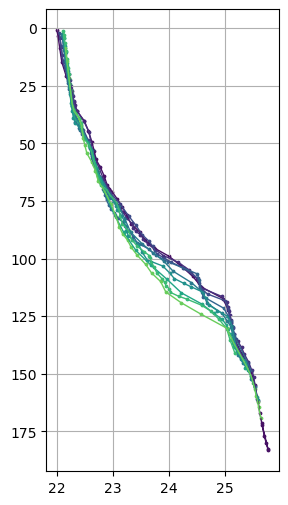

In [220]:
def plot_profile(ds, var, label, separate=True, colormap=mpl.cm.viridis):
    if type(label) == int:
        ds_subset = ds.where(ds.label==label, drop=True)
        plt.scatter(ds_subset[var], ds_subset.depth, s=15)
        plt.plot(ds_subset[var], ds_subset.depth, linewidth=1)
    
    elif type(label) == list:
        for l in label:
            ds_subset = ds.where(ds.label==l, drop=True)
            color = colormap((l+0.5)/(len(label) + 2))
            plt.scatter(ds_subset[var], ds_subset.depth, s=3, color=color)
            plt.plot(ds_subset[var], ds_subset.depth, linewidth=1, color=color)
    #plt.colorbar()
    #plt.xlim(0,0.05)
    if separate:
        plt.show()
plt.figure(figsize=(3,6))
plot_profile(toyo[2], 'sigma', [0,1,2,3,4,5,6,7,8], separate=False)
plt.grid()
plt.gca().invert_yaxis()


In [87]:
toyo[5]

<xarray.Dataset>
Dimensions:      (time: 598)
Coordinates:
  * time         (time) datetime64[ns] 2024-05-21T13:04:00 ... 2024-05-21T15:...
Data variables:
    temp         (time) float64 29.43 29.41 29.36 29.28 ... 29.53 29.58 29.6
    salinity     (time) float64 34.84 34.84 34.84 34.84 ... 34.78 34.78 34.78
    depth        (time) float64 1.069 2.966 5.336 8.297 ... 2.424 1.463 0.8669
    pres         (time) float64 11.21 13.12 15.51 18.5 ... 12.58 11.61 11.01
    sigma        (time) float64 21.8 21.82 21.85 21.89 ... 21.8 21.73 21.71 21.7
    chlorophyll  (time) float64 0.01038 0.01099 0.01163 ... 0.01449 0.01455
    lat          (time) float64 -9.193 -9.193 -9.193 ... -9.32 -9.32 -9.32
    lon          (time) float64 -140.1 -140.1 -140.1 ... -140.0 -140.0 -140.0
    track_dist   (time) float64 0.0 0.03768 0.07514 0.1133 ... 20.85 20.89 20.93
    label        (time) float64 0.0 0.0 0.0 0.0 0.0 ... 11.0 11.0 11.0 11.0 nan
Attributes:
    cruise:       S315
    station:      014
    tow:          5
    description:

In [5]:
# calculate buoyancy frequency from density profiles 
buoyancy_freq = {}
for i in range(2,8):
    ds = toyo[i]
    buoyancy_freq[i] = {}
    for j in np.unique(ds.label):
        if np.isnan(j): continue
        ds_subset = ds.where(ds.label==j, drop=True)
        SA = gsw.SA_from_SP(ds_subset.salinity, ds_subset.pres, ds_subset.lon, ds_subset.lat)
        CT = gsw.CT_from_t(SA, ds_subset.temp, ds_subset.pres)
        result = gsw.Nsquared(SA, CT, ds_subset.pres)
        buoyancy_freq[i][int(j)] = np.sqrt(result[0])
        
    

/var/folders/3n/bmln3m1s2b15c_dvp93gxmlr0000gn/T/ipykernel_2434/957752156.py:12: RuntimeWarning: invalid value encountered in sqrt
  buoyancy_freq[i][int(j)] = np.sqrt(result[0])
/var/folders/3n/bmln3m1s2b15c_dvp93gxmlr0000gn/T/ipykernel_2434/957752156.py:12: RuntimeWarning: invalid value encountered in sqrt
  buoyancy_freq[i][int(j)] = np.sqrt(result[0])
/var/folders/3n/bmln3m1s2b15c_dvp93gxmlr0000gn/T/ipykernel_2434/957752156.py:12: RuntimeWarning: invalid value encountered in sqrt
  buoyancy_freq[i][int(j)] = np.sqrt(result[0])
/var/folders/3n/bmln3m1s2b15c_dvp93gxmlr0000gn/T/ipykernel_2434/957752156.py:12: RuntimeWarning: invalid value encountered in sqrt
  buoyancy_freq[i][int(j)] = np.sqrt(result[0])
/var/folders/3n/bmln3m1s2b15c_dvp93gxmlr0000gn/T/ipykernel_2434/957752156.py:12: RuntimeWarning: invalid value encountered in sqrt
  buoyancy_freq[i][int(j)] = np.sqrt(result[0])
/var/folders/3n/bmln3m1s2b15c_dvp93gxmlr0000gn/T/ipykernel_2434/957752156.py:12: RuntimeWarning: invalid 

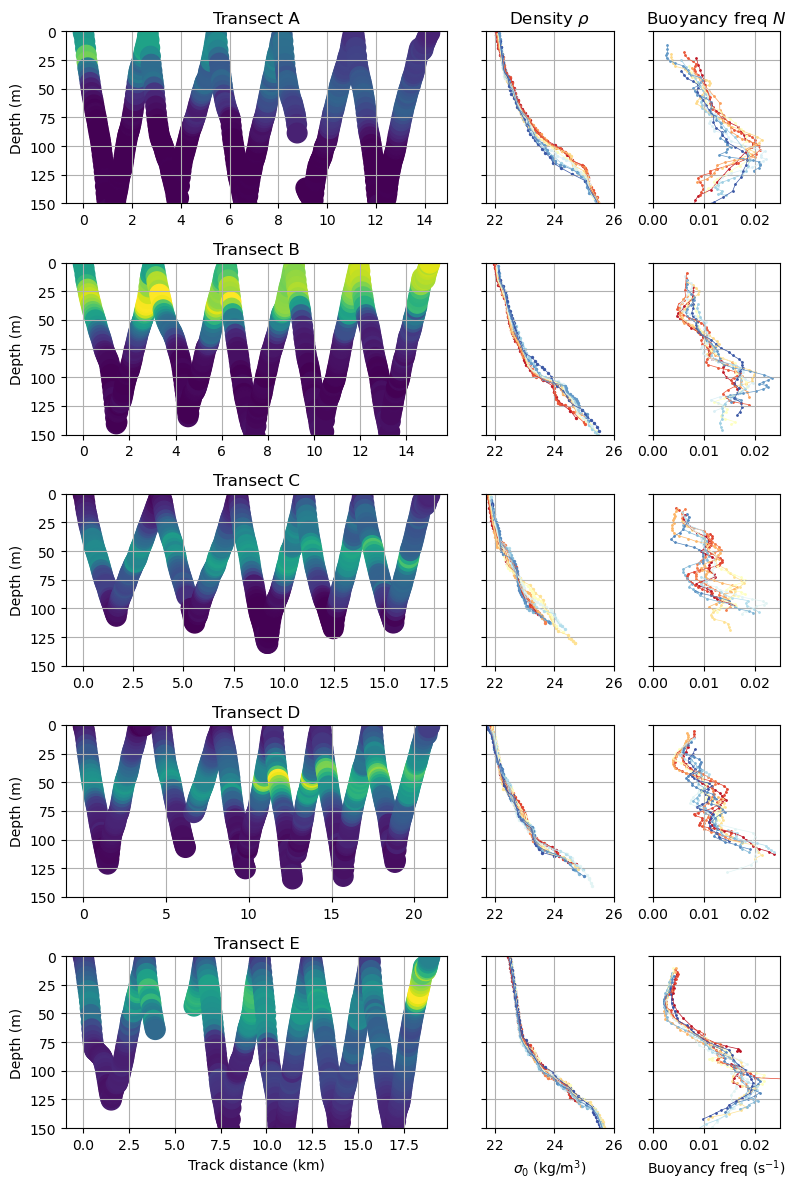

In [215]:
def moving_mean(data, n):
    """
    Calculate the running mean of a sequence with a specified window size using np.convolve.

    Args:
    - data (list or numpy array): The input sequence.
    - n (int): The size of the window.

    Returns:
    - numpy array: An array containing the running mean values.
    """
    # Define a boxcar filter with the specified window size
    boxcar_filter = np.ones(n) / n

    # Use np.convolve to calculate the running mean
    moving_mean = np.convolve(data, boxcar_filter, mode='valid')
    
    return moving_mean

fig, axs = plt.subplots(5, 3, sharey="row",
                    gridspec_kw=dict(height_ratios=[1,1,1,1,1],
                    width_ratios=[3,1,1]), figsize=(8,12), tight_layout=True)

toyos_to_plot = transect_label.keys()
max_depth = 150

for i,idx in enumerate(toyos_to_plot):
    for j in range(3):
        axs[i,j].invert_yaxis()
        if j == 0:
            axs[i,j].grid()
            axs[i,j].scatter(toyo[idx].track_dist, toyo[idx].depth, c=toyo[idx].chlorophyll, s=200,
                            vmin=0.01, vmax=0.035)
            axs[i,j].set_ylim(max_depth, 0)
            axs[i,j].set_ylabel('Depth (m)')
            axs[i,j].set_title(f'Transect {transect_label[idx]}')
            if i == len(toyos_to_plot)-1: axs[i,j].set_xlabel('Track distance (km)')
        if j == 1:
            n_labels = int(np.max(toyo[idx].label))
            for l in range(n_labels):
                ds_subset = toyo[idx].where(toyo[idx].label==l, drop=True)
                color = mpl.cm.RdYlBu((l+0.5)/(n_labels))
                axs[i,j].scatter(ds_subset['sigma'], ds_subset.depth, s=2, color=color)
                axs[i,j].plot(ds_subset['sigma'], ds_subset.depth, linewidth=0.5, color=color)
                axs[i,j].grid()
                axs[i,j].set_xlim(21.7,26)
                if i == 0: axs[i,j].set_title(r'Density $\rho$')
                if i == len(toyos_to_plot)-1: axs[i,j].set_xlabel(r'$\sigma_0$ (kg/m$^3$)')
        if j == 2:
            n_labels = int(np.max(toyo[idx].label))
            for l in range(n_labels):
                ds_subset = toyo[idx].where(toyo[idx].label==l, drop=True)
                color = mpl.cm.RdYlBu((l+0.5)/(n_labels))
                depth_midpoints = ds_subset.depth[0:-1] + np.diff(ds_subset.depth)/2
                
                buoyancy_freq_smoothed = moving_mean(buoyancy_freq[idx][l], 9)
                depth_subset = depth_midpoints[4:-4]

                axs[i,j].set_xlim(0, 0.025)
                axs[i,j].grid()
                if buoyancy_freq_smoothed.shape != depth_subset.shape:
                    continue
                
                # axs[i,j].scatter(buoyancy_freq[idx][l], depth_midpoints, s=1, color=color, alpha=0.2)
                # axs[i,j].plot(buoyancy_freq[idx][l], depth_midpoints, linewidth=0.5, color=color, alpha=0.2)

                axs[i,j].scatter(buoyancy_freq_smoothed, depth_subset, s=1, color=color)
                axs[i,j].plot(buoyancy_freq_smoothed, depth_subset, linewidth=0.5, color=color)

                if i == 0: axs[i,j].set_title(r'Buoyancy freq $N$')
                if i == len(toyos_to_plot)-1: axs[i,j].set_xlabel(r'Buoyancy freq (s$^{-1}$)')

plt.savefig('figures/toyo_transects.jpg', dpi=300, bbox_inches='tight')
# plt.scatter(toyo[2].track_dist, toyo[2].depth, c=toyo[2].chlorophyll, s=200,
#             vmin=0.01, vmax=0.025)
# plt.colorbar(extend='both')
# plt.gca().invert_yaxis()
# plt.title('Toyo2')

/var/folders/3n/bmln3m1s2b15c_dvp93gxmlr0000gn/T/ipykernel_20374/343887303.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


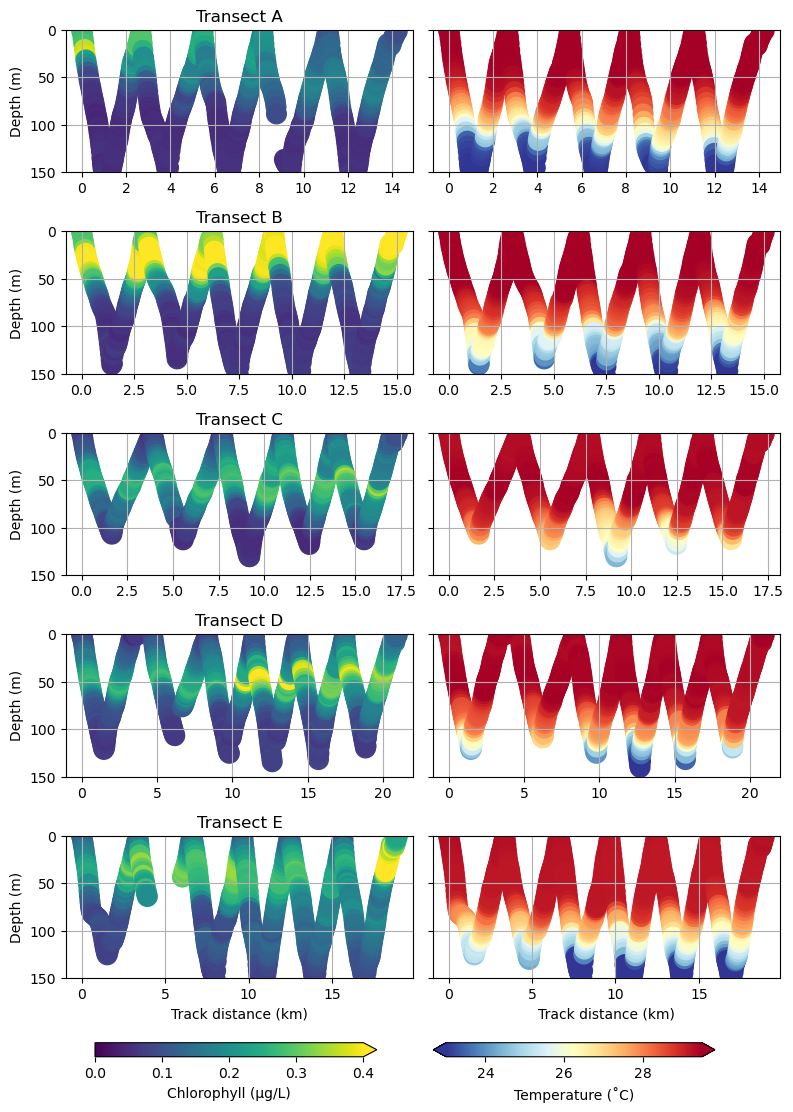

In [627]:
fig, axs = plt.subplots(6, 2, sharey="row", figsize=(8,12), gridspec_kw=dict(height_ratios=[1,1,1,1,1,1],
                    width_ratios=[1,1]))

toyos_to_plot = transect_label.keys()
max_depth = 150

for i,idx in enumerate(toyos_to_plot):
    for j in range(2):
        axs[i,j].invert_yaxis()
        if j == 0:
            axs[i,j].grid()
            im = axs[i,j].scatter(toyo[idx].track_dist, toyo[idx].depth, c=toyo[idx].chlorophyll, 
                            s=200, vmin=0, vmax=0.4)
            axs[i,j].set_ylim(max_depth, 0)
            axs[i,j].set_ylabel('Depth (m)')
            axs[i,j].set_title(f'Transect {transect_label[idx]}')
            if i == len(toyos_to_plot)-1: 
                axs[i,j].set_xlabel('Track distance (km)')
                ax, _ = mpl.colorbar.make_axes(axs[5,0], location='bottom')
                cbar = plt.colorbar(mappable=im, cax=ax, orientation='horizontal', extend='max')
                cbar.set_label('Chlorophyll (µg/L)')
        if j == 1:
            axs[i,j].grid()
            im = axs[i,j].scatter(toyo[idx].track_dist, toyo[idx].depth, c=toyo[idx].temp, 
                            s=200, cmap='RdYlBu_r', vmin=23, vmax=29.5)
            axs[i,j].set_ylim(max_depth, 0)
            #axs[i,j].set_title(f'Transect {transect_label[idx]}')
            if i == len(toyos_to_plot)-1: 
                axs[i,j].set_xlabel('Track distance (km)')
                ax, _ = mpl.colorbar.make_axes(axs[5,1], location='bottom')
                cbar = plt.colorbar(mappable=im, cax=ax, orientation='horizontal', extend='both')
                cbar.set_label('Temperature (˚C)')

# remove auxiliary axes
axs[5,0].remove()
axs[5,1].remove()
plt.tight_layout()
plt.savefig('figures/toyo_transects_color.jpg', dpi=300, bbox_inches='tight')

transect 0 leg 0: mixed layer depth = 3.4333400000000003
transect 0 leg 1: mixed layer depth = 8.252500000000001
transect 0 leg 2: mixed layer depth = 7.551866666666666
transect 0 leg 3: mixed layer depth = 7.616706666666668
transect 0 leg 4: mixed layer depth = 9.44244
transect 0 leg 5: mixed layer depth = 13.479040000000001
transect 0 leg 6: mixed layer depth = 8.402033333333332
transect 0 leg 7: mixed layer depth = 9.820006666666666
transect 0 leg 8: mixed layer depth = 14.04962666666667
transect 1 leg 0: mixed layer depth = 5.114353333333335
transect 1 leg 1: mixed layer depth = 10.911553333333334
transect 1 leg 2: mixed layer depth = 12.317533333333333
transect 1 leg 3: mixed layer depth = 10.302166666666668
transect 1 leg 4: mixed layer depth = 8.340359999999999
transect 1 leg 5: mixed layer depth = 13.587566666666667
transect 1 leg 6: mixed layer depth = 15.352673333333334
transect 1 leg 7: mixed layer depth = 9.242219999999998
transect 1 leg 8: mixed layer depth = 14.81744


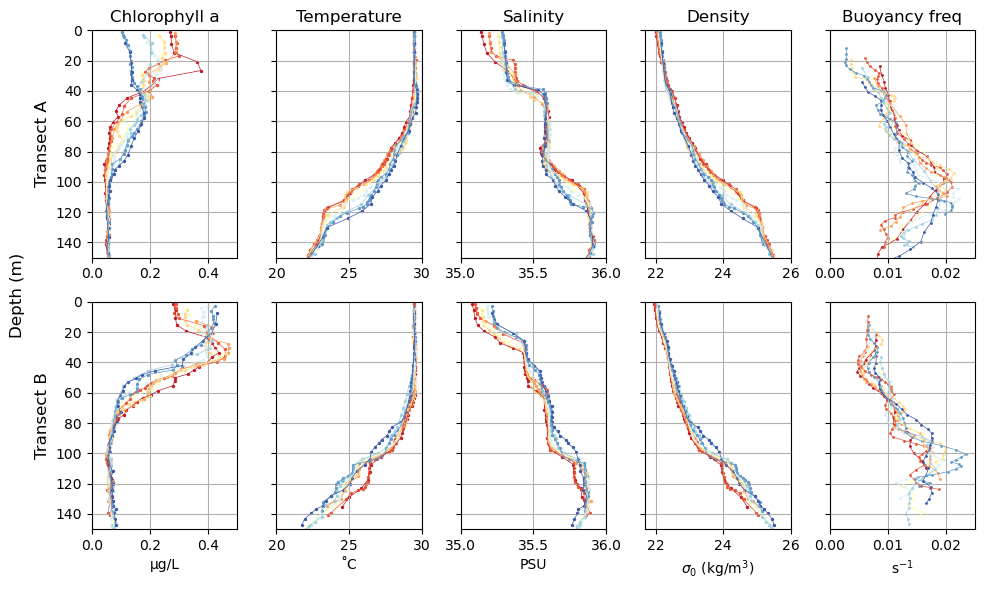

In [19]:
fig, axs = plt.subplots(2, 5, sharey="row",
                    gridspec_kw=dict(height_ratios=[1,1],
                    width_ratios=[1,1,1,1,1]), figsize=(10,6), tight_layout=True)

toyos_to_plot = [2,3]
max_depth = 150

for i,idx in enumerate(toyos_to_plot):
    for j in range(5):
        axs[i,j].invert_yaxis()
        axs[i,j].set_ylim(150, 0)
        if j == 0:
            axs[i,j].grid()
            n_labels = int(np.max(toyo[idx].label))
            for l in range(n_labels):
                ds_subset = toyo[idx].where(toyo[idx].label==l, drop=True)
                color = mpl.cm.RdYlBu((l+0.5)/(n_labels))
                axs[i,j].scatter(ds_subset['chlorophyll'], ds_subset.depth, s=2, color=color)
                axs[i,j].plot(ds_subset['chlorophyll'], ds_subset.depth, linewidth=0.5, color=color)
            axs[i,j].set_xlim(0, 0.5)
            axs[i,j].set_ylabel(f'Transect {transect_label[idx]}', fontsize=12)
            if i == 0: axs[i,j].set_title(r'Chlorophyll a')
            if i == len(toyos_to_plot)-1: axs[i,j].set_xlabel('µg/L')
        if j == 1:
            axs[i,j].grid()
            n_labels = int(np.max(toyo[idx].label))
            for l in range(n_labels):
                ds_subset = toyo[idx].where(toyo[idx].label==l, drop=True)
                color = mpl.cm.RdYlBu((l+0.5)/(n_labels))
                axs[i,j].scatter(ds_subset['temp'], ds_subset.depth, s=2, color=color)
                axs[i,j].plot(ds_subset['temp'], ds_subset.depth, linewidth=0.5, color=color)
            axs[i,j].set_xlim(20, 30)
            if i == 0: axs[i,j].set_title(r'Temperature')
            if i == len(toyos_to_plot)-1: axs[i,j].set_xlabel('˚C')
        if j == 2:
            axs[i,j].grid()
            n_labels = int(np.max(toyo[idx].label))
            for l in range(n_labels):
                ds_subset = toyo[idx].where(toyo[idx].label==l, drop=True)
                color = mpl.cm.RdYlBu((l+0.5)/(n_labels))
                axs[i,j].scatter(ds_subset['salinity'], ds_subset.depth, s=2, color=color)
                axs[i,j].plot(ds_subset['salinity'], ds_subset.depth, linewidth=0.5, color=color)
            axs[i,j].set_xlim(35, 36)
            if i == 0: axs[i,j].set_title(r'Salinity')
            if i == len(toyos_to_plot)-1: axs[i,j].set_xlabel('PSU')
        if j == 3:
            n_labels = int(np.max(toyo[idx].label))
            for l in range(n_labels):
                ds_subset = toyo[idx].where(toyo[idx].label==l, drop=True)
                color = mpl.cm.RdYlBu((l+0.5)/(n_labels))
                axs[i,j].scatter(ds_subset['sigma'], ds_subset.depth, s=2, color=color)
                axs[i,j].plot(ds_subset['sigma'], ds_subset.depth, linewidth=0.5, color=color)
                axs[i,j].grid()
                sfc_index = 0 if l % 2 == 0 else -1
                mld_index = np.argmin(np.abs(ds_subset['sigma'] - ds_subset['sigma'][sfc_index] - 0.03).data)
                mld = ds_subset['depth'][mld_index].data
                print(f'transect {i} leg {l}: mixed layer depth = {mld}')
            axs[i,j].set_xlim(21.7,26)
            if i == 0: axs[i,j].set_title(r'Density')
            if i == len(toyos_to_plot)-1: axs[i,j].set_xlabel(r'$\sigma_0$ (kg/m$^3$)')
        if j == 4:
            n_labels = int(np.max(toyo[idx].label))
            for l in range(n_labels):
                ds_subset = toyo[idx].where(toyo[idx].label==l, drop=True)
                color = mpl.cm.RdYlBu((l+0.5)/(n_labels))
                depth_midpoints = ds_subset.depth[0:-1] + np.diff(ds_subset.depth)/2
                
                buoyancy_freq_smoothed = moving_mean(buoyancy_freq[idx][l], 9)
                depth_subset = depth_midpoints[4:-4]

                axs[i,j].set_xlim(0, 0.025)
                axs[i,j].grid()
                if buoyancy_freq_smoothed.shape != depth_subset.shape:
                    continue
                
                # axs[i,j].scatter(buoyancy_freq[idx][l], depth_midpoints, s=1, color=color, alpha=0.2)
                # axs[i,j].plot(buoyancy_freq[idx][l], depth_midpoints, linewidth=0.5, color=color, alpha=0.2)

                axs[i,j].scatter(buoyancy_freq_smoothed, depth_subset, s=1, color=color)
                axs[i,j].plot(buoyancy_freq_smoothed, depth_subset, linewidth=0.5, color=color)

            if i == 0: axs[i,j].set_title(r'Buoyancy freq')
            if i == len(toyos_to_plot)-1: axs[i,j].set_xlabel(r's$^{-1}$')

fig.supylabel('Depth (m)')
plt.savefig('figures/toyo_transect_profiles_2_3_only.jpg', dpi=300, bbox_inches='tight')

transect 0 leg 0: mixed layer depth = 3.4333400000000003
transect 0 leg 1: mixed layer depth = 8.252500000000001
transect 0 leg 2: mixed layer depth = 7.551866666666666
transect 0 leg 3: mixed layer depth = 7.616706666666668
transect 0 leg 4: mixed layer depth = 9.44244
transect 0 leg 5: mixed layer depth = 13.479040000000001
transect 0 leg 6: mixed layer depth = 8.402033333333332
transect 0 leg 7: mixed layer depth = 9.820006666666666
transect 0 leg 8: mixed layer depth = 14.04962666666667
transect 1 leg 0: mixed layer depth = 5.114353333333335
transect 1 leg 1: mixed layer depth = 10.911553333333334
transect 1 leg 2: mixed layer depth = 12.317533333333333
transect 1 leg 3: mixed layer depth = 10.302166666666668
transect 1 leg 4: mixed layer depth = 8.340359999999999
transect 1 leg 5: mixed layer depth = 13.587566666666667
transect 1 leg 6: mixed layer depth = 15.352673333333334
transect 1 leg 7: mixed layer depth = 9.242219999999998
transect 1 leg 8: mixed layer depth = 14.81744
tran

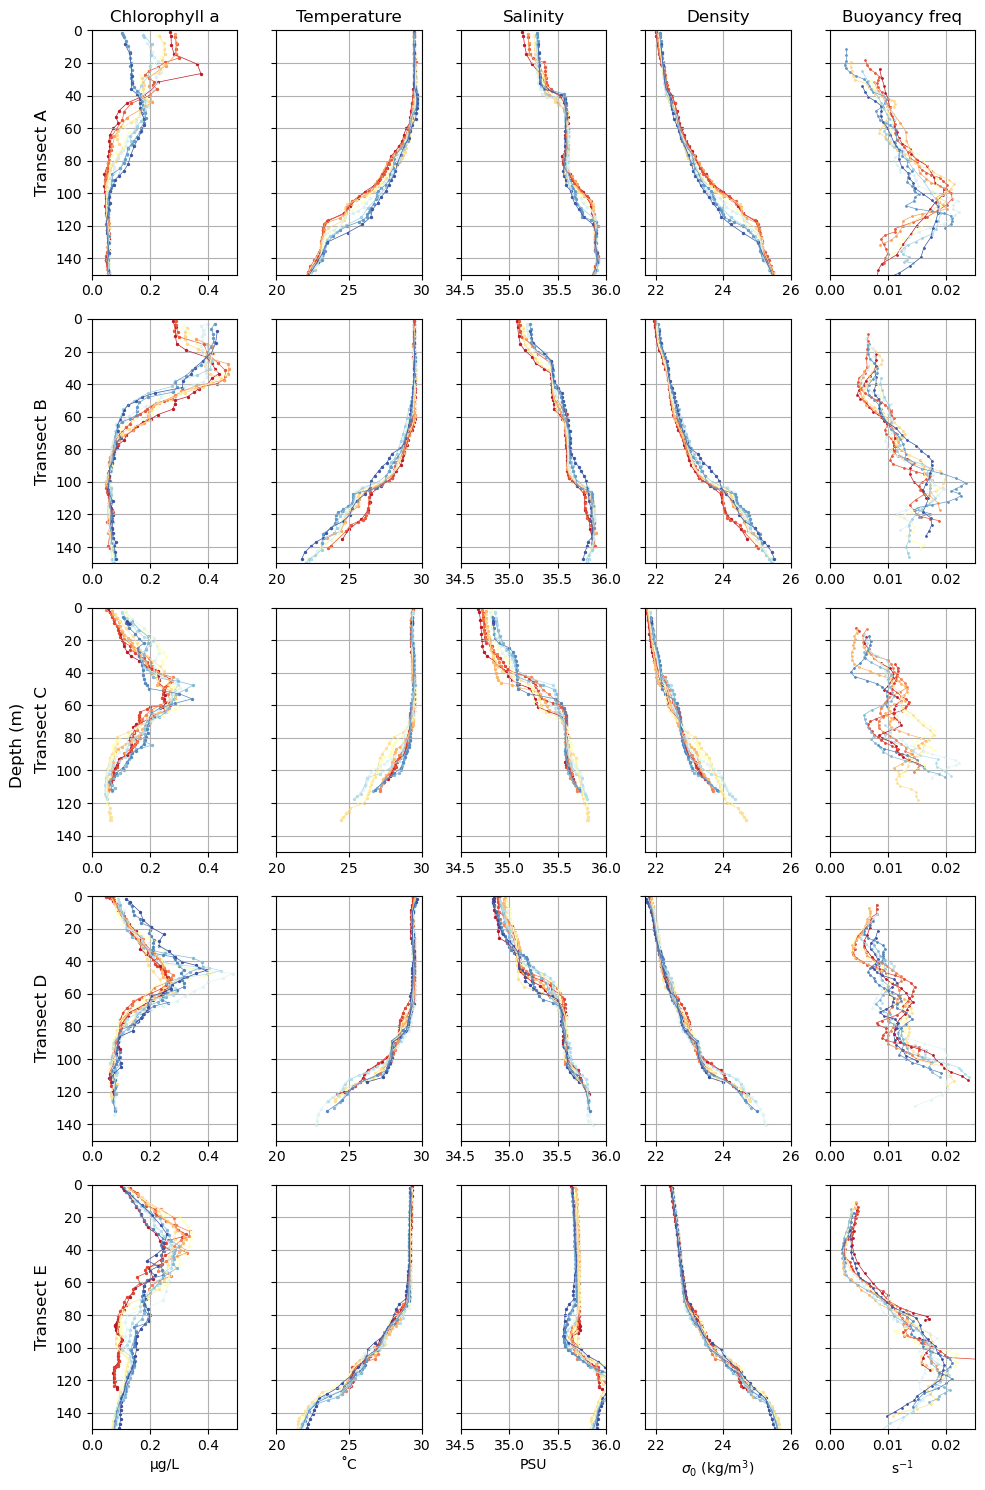

In [17]:
fig, axs = plt.subplots(5, 5, sharey="row",
                    gridspec_kw=dict(height_ratios=[1,1,1,1,1],
                    width_ratios=[1,1,1,1,1]), figsize=(10,15), tight_layout=True)

toyos_to_plot = transect_label.keys()
max_depth = 150

for i,idx in enumerate(toyos_to_plot):
    for j in range(5):
        axs[i,j].invert_yaxis()
        axs[i,j].set_ylim(150, 0)
        if j == 0:
            axs[i,j].grid()
            n_labels = int(np.max(toyo[idx].label))
            for l in range(n_labels):
                ds_subset = toyo[idx].where(toyo[idx].label==l, drop=True)
                color = mpl.cm.RdYlBu((l+0.5)/(n_labels))
                axs[i,j].scatter(ds_subset['chlorophyll'], ds_subset.depth, s=2, color=color)
                axs[i,j].plot(ds_subset['chlorophyll'], ds_subset.depth, linewidth=0.5, color=color)
            axs[i,j].set_xlim(0, 0.5)
            axs[i,j].set_ylabel(f'Transect {transect_label[idx]}', fontsize=12)
            if i == 0: axs[i,j].set_title(r'Chlorophyll a')
            if i == len(toyos_to_plot)-1: axs[i,j].set_xlabel('µg/L')
        if j == 1:
            axs[i,j].grid()
            n_labels = int(np.max(toyo[idx].label))
            for l in range(n_labels):
                ds_subset = toyo[idx].where(toyo[idx].label==l, drop=True)
                color = mpl.cm.RdYlBu((l+0.5)/(n_labels))
                axs[i,j].scatter(ds_subset['temp'], ds_subset.depth, s=2, color=color)
                axs[i,j].plot(ds_subset['temp'], ds_subset.depth, linewidth=0.5, color=color)
            axs[i,j].set_xlim(20, 30)
            if i == 0: axs[i,j].set_title(r'Temperature')
            if i == len(toyos_to_plot)-1: axs[i,j].set_xlabel('˚C')
        if j == 2:
            axs[i,j].grid()
            n_labels = int(np.max(toyo[idx].label))
            for l in range(n_labels):
                ds_subset = toyo[idx].where(toyo[idx].label==l, drop=True)
                color = mpl.cm.RdYlBu((l+0.5)/(n_labels))
                axs[i,j].scatter(ds_subset['salinity'], ds_subset.depth, s=2, color=color)
                axs[i,j].plot(ds_subset['salinity'], ds_subset.depth, linewidth=0.5, color=color)
            axs[i,j].set_xlim(34.5, 36)
            if i == 0: axs[i,j].set_title(r'Salinity')
            if i == len(toyos_to_plot)-1: axs[i,j].set_xlabel('PSU')
        if j == 3:
            n_labels = int(np.max(toyo[idx].label))
            for l in range(n_labels):
                ds_subset = toyo[idx].where(toyo[idx].label==l, drop=True)
                color = mpl.cm.RdYlBu((l+0.5)/(n_labels))
                axs[i,j].scatter(ds_subset['sigma'], ds_subset.depth, s=2, color=color)
                axs[i,j].plot(ds_subset['sigma'], ds_subset.depth, linewidth=0.5, color=color)
                axs[i,j].grid()
                sfc_index = 0 if l % 2 == 0 else -1
                mld_index = np.argmin(np.abs(ds_subset['sigma'] - ds_subset['sigma'][sfc_index] - 0.03).data)
                mld = ds_subset['depth'][mld_index].data
                print(f'transect {i} leg {l}: mixed layer depth = {mld}')
            axs[i,j].set_xlim(21.7,26)
            if i == 0: axs[i,j].set_title(r'Density')
            if i == len(toyos_to_plot)-1: axs[i,j].set_xlabel(r'$\sigma_0$ (kg/m$^3$)')
        if j == 4:
            n_labels = int(np.max(toyo[idx].label))
            for l in range(n_labels):
                ds_subset = toyo[idx].where(toyo[idx].label==l, drop=True)
                color = mpl.cm.RdYlBu((l+0.5)/(n_labels))
                depth_midpoints = ds_subset.depth[0:-1] + np.diff(ds_subset.depth)/2
                
                buoyancy_freq_smoothed = moving_mean(buoyancy_freq[idx][l], 9)
                depth_subset = depth_midpoints[4:-4]

                axs[i,j].set_xlim(0, 0.025)
                axs[i,j].grid()
                if buoyancy_freq_smoothed.shape != depth_subset.shape:
                    continue
                
                # axs[i,j].scatter(buoyancy_freq[idx][l], depth_midpoints, s=1, color=color, alpha=0.2)
                # axs[i,j].plot(buoyancy_freq[idx][l], depth_midpoints, linewidth=0.5, color=color, alpha=0.2)

                axs[i,j].scatter(buoyancy_freq_smoothed, depth_subset, s=1, color=color)
                axs[i,j].plot(buoyancy_freq_smoothed, depth_subset, linewidth=0.5, color=color)

            if i == 0: axs[i,j].set_title(r'Buoyancy freq')
            if i == len(toyos_to_plot)-1: axs[i,j].set_xlabel(r's$^{-1}$')

fig.supylabel('Depth (m)')
plt.savefig('figures/toyo_transect_profiles_all.jpg', dpi=300, bbox_inches='tight')

In [29]:
ds_subset['sigma']

<xarray.DataArray 'sigma' (time: 44)>
array([22.00675   , 22.02676   , 22.0579    , 22.09493333, 22.17206667,
       22.25309333, 22.30450667, 22.36978   , 22.49717333, 22.56798   ,
       22.62936   , 22.67272   , 22.70331333, 22.78087333, 22.84994   ,
       22.90216   , 22.99690667, 23.08385333, 23.17185333, 23.25152   ,
       23.32812667, 23.485     , 23.57956   , 23.73840667, 24.00744   ,
       24.21246   , 24.43058   , 24.58453333, 24.97198667, 25.06641333,
       25.12086   , 25.17508667, 25.29799333, 25.40213333, 25.47655333,
       25.54084667, 25.59818   , 25.62653333, 25.66854667, 25.70752   ,
       25.74404   , 25.77946667, 25.77313333, 25.66257333])
Coordinates:
  * time     (time) datetime64[ns] 2024-05-18T05:52:45 ... 2024-05-18T06:03:30

In [44]:
toyo[7]

<xarray.Dataset>
Dimensions:      (time: 596)
Coordinates:
  * time         (time) datetime64[ns] 2024-05-22T10:41:45 ... 2024-05-22T13:...
Data variables:
    temp         (time) float64 29.32 29.32 29.31 29.31 ... 29.27 29.27 29.27
    salinity     (time) float64 35.64 35.65 35.66 35.66 ... 35.62 35.62 35.61
    depth        (time) float64 ...
    pres         (time) float64 ...
    sigma        (time) float64 ...
    chlorophyll  (time) float64 ...
    lat          (time) float64 ...
    lon          (time) float64 ...
    track_dist   (time) float64 ...
    label        (time) float64 0.0 0.0 0.0 0.0 0.0 ... 11.0 11.0 11.0 nan nan
Attributes:
    cruise:       S315
    station:      016
    tow:          7
    description:

## Plot surface maps

### first, prep the satellite files

In [195]:
def open_mfdataset(parent_path):
    '''
        Opens all files in parent_path, appending by time dimension (times must be unique)
    '''
    files_to_open = []
    for path in os.listdir(parent_path):
        files_to_open.append(os.path.join(parent_path, path))
    print(files_to_open)
    return xr.open_mfdataset(files_to_open)

chl_modis = open_mfdataset('/Users/yuchenli/Documents/Stanford@SEA/project/data/3-day 0.025 degree aquaModis')
#chl_modis.to_netcdf('../data/3-day 0.025 degree aquaModis/combined.nc')

sst = open_mfdataset('../Data/SST')
#sst.to_netcdf('../data/SST/combined.nc')

ssha = open_mfdataset('../Data/SSHA')
ssha.to_netcdf('../data/SSHA/combined.nc')

['/Users/yuchenli/Documents/Stanford@SEA/project/data/3-day 0.025 degree aquaModis/erdMBchla3day_e38b_c13a_34ce_U1717891996711.nc', '/Users/yuchenli/Documents/Stanford@SEA/project/data/3-day 0.025 degree aquaModis/erdMBchla3day_1f6c_7afc_e71f_U1717891898763.nc', '/Users/yuchenli/Documents/Stanford@SEA/project/data/3-day 0.025 degree aquaModis/erdMBchla3day_8b70_222a_f7c6_U1717891930051.nc', '/Users/yuchenli/Documents/Stanford@SEA/project/data/3-day 0.025 degree aquaModis/erdMBchla3day_c367_e362_d246_U1717891853412.nc', '/Users/yuchenli/Documents/Stanford@SEA/project/data/3-day 0.025 degree aquaModis/erdMBchla3day_d4c4_24e2_e80b_U1717891956678.nc', '/Users/yuchenli/Documents/Stanford@SEA/project/data/3-day 0.025 degree aquaModis/erdMBchla3day_b715_5acf_6062_U1717891799115.nc', '/Users/yuchenli/Documents/Stanford@SEA/project/data/3-day 0.025 degree aquaModis/combined.nc', '/Users/yuchenli/Documents/Stanford@SEA/project/data/3-day 0.025 degree aquaModis/erdMBchla3day_f9aa_bc05_f2fb_U17178

In [20]:
chla_satellite = xr.open_dataset('../data/3-day 0.025 degree aquaModis/combined.nc')
sst_satellite = xr.open_dataset('../data/SST/combined.nc')
ssha_satellite = xr.open_dataset('../data/SSHA/combined.nc')

In [151]:
chla_satellite

<xarray.Dataset>
Dimensions:      (time: 21, altitude: 1, latitude: 281, longitude: 521)
Coordinates:
  * time         (time) datetime64[ns] 2024-05-17T12:00:00 ... 2024-06-06T12:...
  * altitude     (altitude) float64 0.0
  * latitude     (latitude) float64 -13.0 -12.97 -12.95 ... -6.05 -6.025 -6.0
  * longitude    (longitude) float64 214.0 214.0 214.1 ... 226.9 227.0 227.0
Data variables:
    chlorophyll  (time, altitude, latitude, longitude) float32 ...
Attributes: (12/56)
    acknowledgement:               NOAA NESDIS COASTWATCH, NOAA SWFSC ERD
    cdm_data_type:                 Grid
    composite:                     true
    contributor_name:              NASA GSFC (OBPG)
    contributor_role:              Source of level 2 data.
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    ...                            ...
    summary:                       NOAA CoastWatch distributes chlorophyll-a ...
    testOutOfDate:                 now-4days
    time_coverage_end:             2024-05-17T12:00:00Z
    time_coverage_start:           2024-05-17T12:00:00Z
    title:                         Chlorophyll-a, Aqua MODIS, NPP, 0.025 degr...
    Westernmost_Easting:           214.0

In [22]:
# plot a map of the toyo transects 
elg = xr.open_dataset('../data/derived shipdata/elg.nc')

def format_map(ax, leg=[0,1], extent=[-142, -138, -11, -8]):
    if leg == 0:
        toyos_to_plot = [2,3,4]
    elif leg == 1:
        toyos_to_plot = [5,7]
    elif leg == [0,1]:
        toyos_to_plot = [2,3,4,5,7]

    for j in toyos_to_plot:
        ax.plot(toyo[j].lon, toyo[j].lat, transform=ccrs.PlateCarree(), color='k')

    if leg == 0 or leg == [0,1]:
        ax.text(-141.5, -9.45, 'A', transform=ccrs.PlateCarree())
        ax.text(-140.9, -9.25, 'B', transform=ccrs.PlateCarree())
        ax.text(-140.4, -8.75, 'C', transform=ccrs.PlateCarree())
        if leg == [0,1]:
            ax.text(-140, -9.2, 'D', transform=ccrs.PlateCarree())
            ax.text(-138.8, -10.2, 'E', transform=ccrs.PlateCarree())
    elif leg == 1:
        ax.text(-140, -9.2, 'D', transform=ccrs.PlateCarree())
        ax.text(-138.8, -10.2, 'E', transform=ccrs.PlateCarree())

    #ax.scatter(gps_position.lon, gps_position.lat, s=1, color='grey')
    ax.set_xticks(np.linspace(-142, -138, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(-11, -8, 4), crs=ccrs.PlateCarree())
    ax.set_extent(extent)
    ax.coastlines()
    ax.grid()


In [ ]:

fig = plt.figure(figsize=(6,4))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
format_map(ax)
ax.contourf(sst_satellite_time_avg.longitude, 
           sst_satellite_time_avg.latitude,
           sst_satellite_time_avg, vmin=29, vmax=30, cmap='coolwarm', linewidth=1)
im = ax.scatter(elg.lon, elg.lat, c=elg.temp, s=30, vmin=29, vmax=30, cmap='coolwarm')
cbar = plt.colorbar(im, shrink=0.9, extend='both')
cbar.set_label('SST (˚C)')
plt.show()
#plt.savefig('figures/SST.svg', bbox_inches='tight')

fig = plt.figure(figsize=(6,4))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
format_map(ax)
im = ax.scatter(elg.lon, elg.lat, c=elg.salinity, s=30, vmin=35, vmax=36, cmap='BrBG_r')
cbar = plt.colorbar(im, shrink=0.9, extend='both')
cbar.set_label('Salinity')
plt.show()


In [156]:
print(chla_satellite.time[4])

<xarray.DataArray 'time' ()>
array('2024-05-21T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2024-05-21T12:00:00
Attributes:
    _CoordinateAxisType:  Time
    actual_range:         [1.7159472e+09 1.7159472e+09]
    axis:                 T
    fraction_digits:      0
    ioos_category:        Time
    long_name:            Centered Time
    standard_name:        time
    time_origin:          01-JAN-1970 00:00:00


<xarray.DataArray 'chlorophyll' ()>
array(nan, dtype=float32)
Coordinates:
    time      datetime64[ns] 2024-05-20T12:00:00
    altitude  float64 0.0
<xarray.DataArray 'chlorophyll' ()>
array(0.09610092, dtype=float32)
Coordinates:
    time      datetime64[ns] 2024-05-23T12:00:00
    altitude  float64 0.0


/var/folders/3n/bmln3m1s2b15c_dvp93gxmlr0000gn/T/ipykernel_2434/814488263.py:28: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar2 = plt.colorbar(im2, shrink=0.25, extend='max', location='left', ticklocation='right')


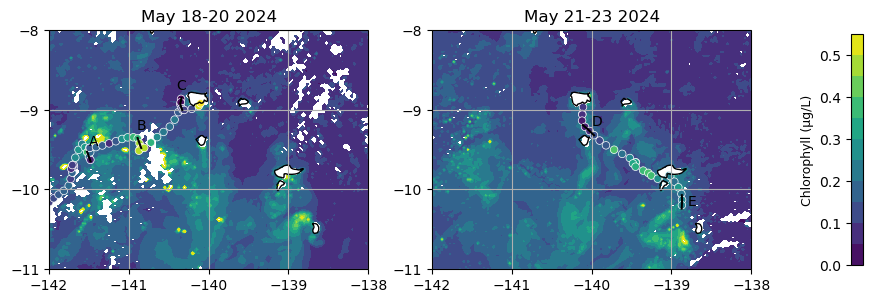

In [25]:

fig = plt.figure(figsize=(14,12))
ax = plt.subplot(1,3,1, projection=ccrs.PlateCarree())
format_map(ax, leg=0)
elg_subset = elg.isel(time=slice(0,221))
chla_satellite_time_avg = chla_satellite.chlorophyll.isel(time=3, altitude=0)
ax.contourf(chla_satellite_time_avg.longitude, 
           chla_satellite_time_avg.latitude,
           chla_satellite_time_avg, np.arange(0, 0.6, 0.05), cmap='viridis')
im = ax.scatter(elg_subset.lon, elg_subset.lat, c=elg_subset.fluor, 
                s=30, vmin=5, vmax=18, cmap='viridis', linewidths=0.5, edgecolors='w')
ax.set_title('May 18-20 2024')

ax = plt.subplot(1,3,2, projection=ccrs.PlateCarree())
format_map(ax, leg=1)
elg_subset = elg.isel(time=slice(221,289))
chla_satellite_time_avg = chla_satellite.chlorophyll.isel(time=6, altitude=0)
print(chla_satellite_time_avg.mean(dim=['latitude', 'longitude']))
im2 = ax.contourf(chla_satellite_time_avg.longitude, 
           chla_satellite_time_avg.latitude,
           chla_satellite_time_avg, np.arange(0, 0.6, 0.05), cmap='viridis')
im = ax.scatter(elg_subset.lon, elg_subset.lat, c=elg_subset.fluor, 
                s=30, vmin=5, vmax=18, cmap='viridis', linewidths=0.5, edgecolors='w')
ax.set_title('May 21-23 2024')

ax = plt.subplot(1,3,3)
#cbar = plt.colorbar(im, shrink=0.3, extend='both', location='left')
cbar2 = plt.colorbar(im2, shrink=0.25, extend='max', location='left', ticklocation='right')
#cbar.set_label('Fluorescence (arbitrary units)', fontsize=9)
cbar2.set_label('Chlorophyll (µg/L)', fontsize=9)
ax.remove()
#plt.savefig('figures/chlorophyll_map.jpg', dpi=300, bbox_inches='tight')
#plt.savefig('figures/chlorophyll_map.svg', bbox_inches='tight')

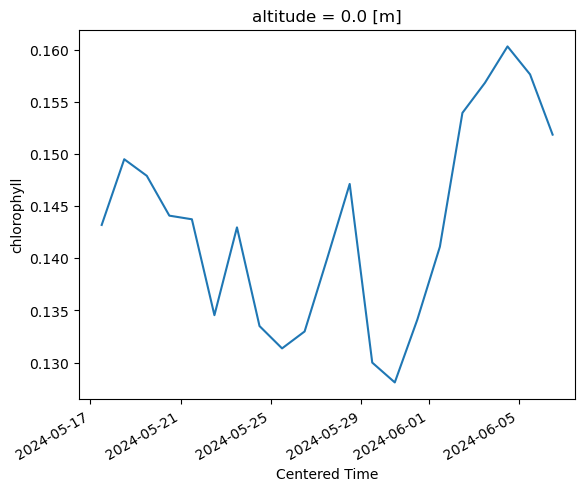

In [35]:
chla_satellite.chlorophyll.sel(latitude=slice(-11, -8), longitude=slice(218, 222), altitude=0).mean(dim=['latitude','longitude']).plot()


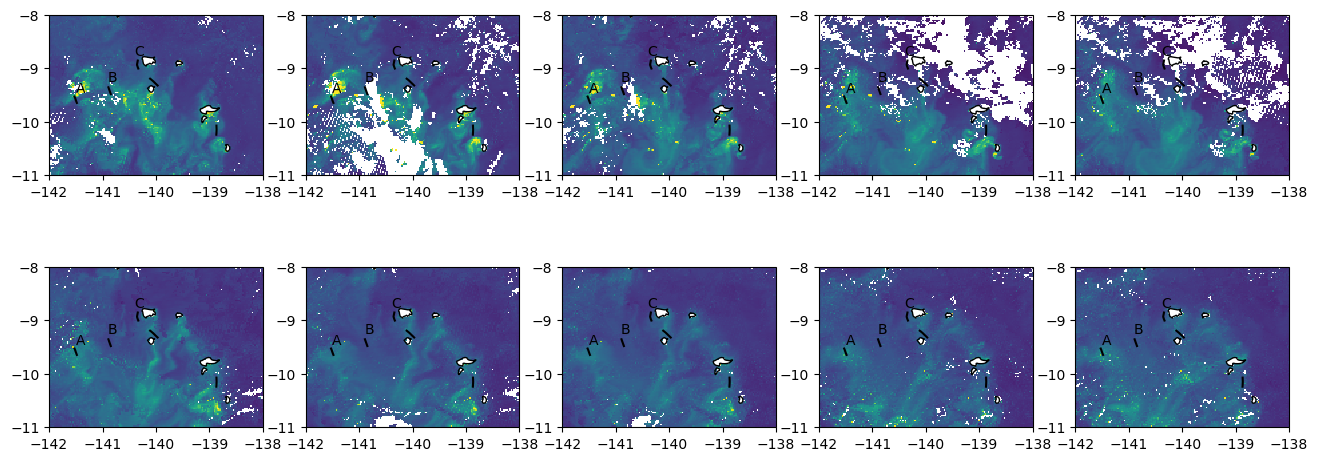

In [203]:
fig = plt.figure(figsize=(16,6))
for i in range(1,11):
    ax = plt.subplot(2,5,i, projection=ccrs.PlateCarree())
    format_map(ax, leg=[0,1])
    elg_subset = elg.isel(time=slice(0,221))
    chla_satellite_time_avg = chla_satellite.chlorophyll.isel(time=i, altitude=0)
    ax.pcolormesh(chla_satellite_time_avg.longitude, 
            chla_satellite_time_avg.latitude,
            chla_satellite_time_avg, vmin=0, vmax=0.55, cmap='viridis')


/var/folders/3n/bmln3m1s2b15c_dvp93gxmlr0000gn/T/ipykernel_34304/1522965207.py:26: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar2 = plt.colorbar(im2, shrink=0.25, extend='max', location='left', ticklocation='right')


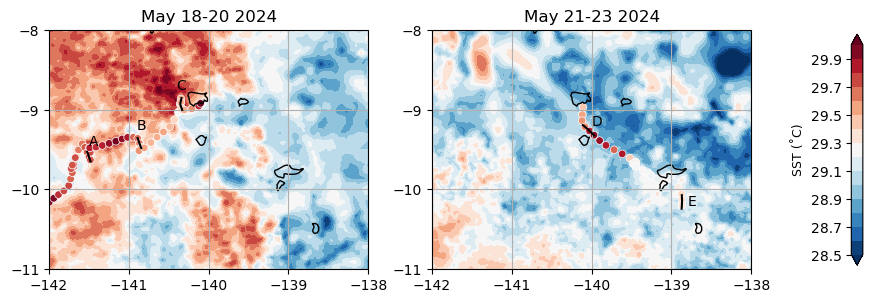

In [204]:

fig = plt.figure(figsize=(14,12))
ax = plt.subplot(1,3,1, projection=ccrs.PlateCarree())
format_map(ax, leg=0)
elg_subset = elg.isel(time=slice(0,221))
sst_satellite_time_avg = sst_satellite.analysed_sst.isel(time=slice(1,3)).mean('time')
ax.contourf(sst_satellite_time_avg.longitude, 
           sst_satellite_time_avg.latitude,
           sst_satellite_time_avg, np.arange(28.5, 30.05, 0.1), cmap='RdBu_r', extend='both')
im = ax.scatter(elg_subset.lon, elg_subset.lat, c=elg_subset.temp, 
                s=30, vmin=29, vmax=30, cmap='RdBu_r', linewidths=0.5, edgecolors='w')
ax.set_title('May 18-20 2024')

ax = plt.subplot(1,3,2, projection=ccrs.PlateCarree())
format_map(ax, leg=1)
elg_subset = elg.isel(time=slice(221,289))
sst_satellite_time_avg = sst_satellite.analysed_sst.isel(time=slice(4,6)).mean('time')
im2 = ax.contourf(sst_satellite_time_avg.longitude, 
           sst_satellite_time_avg.latitude,
           sst_satellite_time_avg, np.arange(28.5, 30.05, 0.1), cmap='RdBu_r', extend='both')
im = ax.scatter(elg_subset.lon, elg_subset.lat, c=elg_subset.temp, 
                s=30, vmin=29, vmax=30, cmap='RdBu_r', linewidths=0.5, edgecolors='w')
ax.set_title('May 21-23 2024')

ax = plt.subplot(1,3,3)
#cbar = plt.colorbar(im, shrink=0.3, extend='both', location='left')
cbar2 = plt.colorbar(im2, shrink=0.25, extend='max', location='left', ticklocation='right')
#cbar.set_label('Fluorescence (arbitrary units)', fontsize=9)
cbar2.set_label('SST (˚C)', fontsize=9)
ax.remove()
plt.savefig('figures/sst_map.jpg', dpi=300, bbox_inches='tight')
plt.savefig('figures/sst_map.svg', bbox_inches='tight')

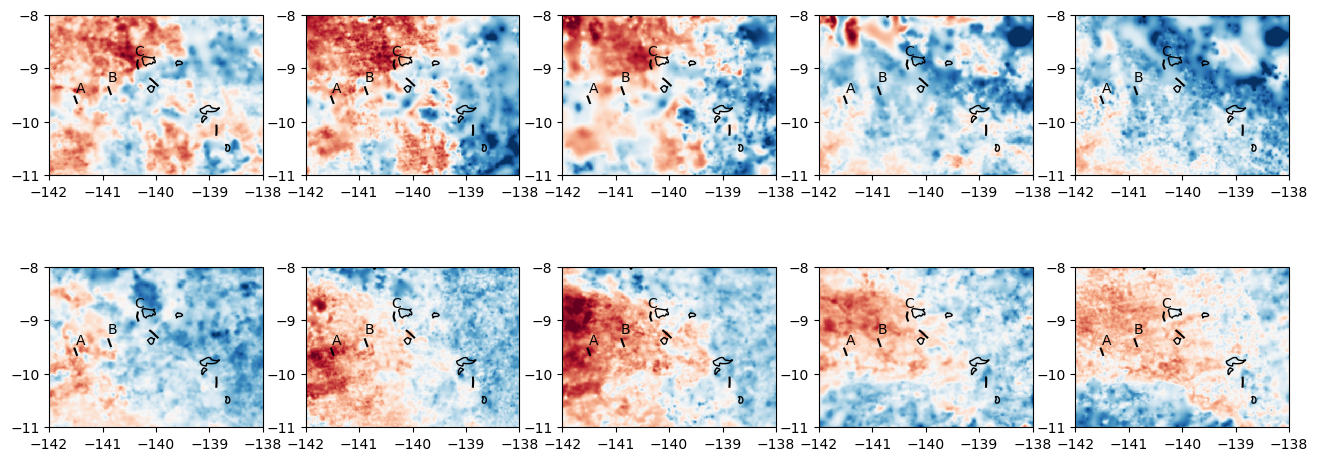

In [205]:
fig = plt.figure(figsize=(16,6))
for i in range(1,11):
    ax = plt.subplot(2,5,i, projection=ccrs.PlateCarree())
    format_map(ax, leg=[0,1])
    elg_subset = elg.isel(time=slice(0,221))
    sst_satellite_time_avg = sst_satellite.analysed_sst.isel(time=i)
    ax.pcolormesh(sst_satellite_time_avg.longitude, 
            sst_satellite_time_avg.latitude,
            sst_satellite_time_avg, vmin=28.5, vmax=30, cmap='RdBu_r')


/var/folders/3n/bmln3m1s2b15c_dvp93gxmlr0000gn/T/ipykernel_34304/3596948507.py:22: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar2 = plt.colorbar(im2, shrink=0.25, extend='max', location='left', ticklocation='right')


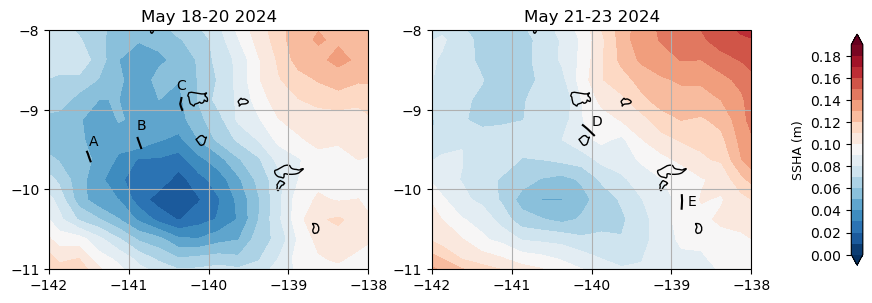

In [207]:

fig = plt.figure(figsize=(14,12))
ax = plt.subplot(1,3,1, projection=ccrs.PlateCarree())
format_map(ax, leg=0)
elg_subset = elg.isel(time=slice(0,221))
ssha = ssha_satellite.sla.isel(time=slice(1,3)).mean('time')
ax.contourf(ssha.longitude, 
           ssha.latitude,
           ssha, np.arange(0, 0.2, 0.01), cmap='RdBu_r', extend='both')
ax.set_title('May 18-20 2024')

ax = plt.subplot(1,3,2, projection=ccrs.PlateCarree())
format_map(ax, leg=1)
elg_subset = elg.isel(time=slice(221,289))
ssha = ssha_satellite.sla.isel(time=slice(4,6)).mean('time')
im2 = ax.contourf(ssha.longitude, 
           ssha.latitude,
           ssha, np.arange(0, 0.2, 0.01), cmap='RdBu_r', extend='both')
ax.set_title('May 21-23 2024')

ax = plt.subplot(1,3,3)
#cbar = plt.colorbar(im, shrink=0.3, extend='both', location='left')
cbar2 = plt.colorbar(im2, shrink=0.25, extend='max', location='left', ticklocation='right')
#cbar.set_label('Fluorescence (arbitrary units)', fontsize=9)
cbar2.set_label('SSHA (m)', fontsize=9)
ax.remove()
plt.savefig('figures/ssha_map.jpg', dpi=300, bbox_inches='tight')
plt.savefig('figures/ssha_map.svg', bbox_inches='tight')